In [30]:
import pandas as pd
data=pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


In [31]:
data['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [32]:
numeric_column=data.select_dtypes(include=['number'])
numeric_column_name= data.select_dtypes(include=['number']).columns
numeric_column_name=list(numeric_column_name)

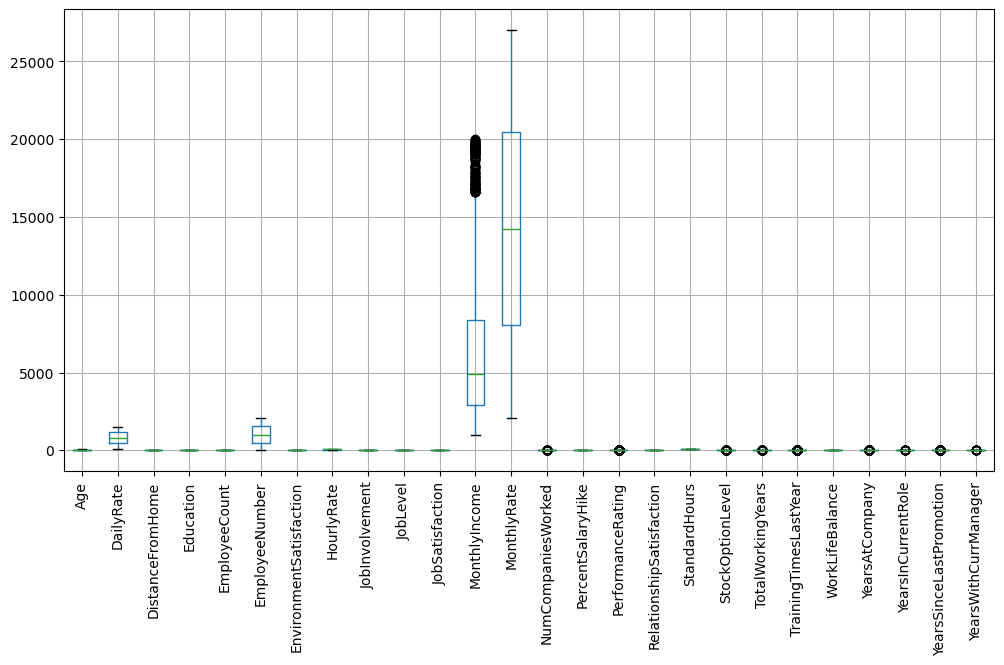

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data.boxplot(column=numeric_column_name)
plt.xticks(rotation=90)
plt.show()

In [34]:
Q1=data['MonthlyIncome'].quantile(0.25)
Q3=data['MonthlyIncome'].quantile(0.75)
IQR= Q3-Q1
lower_limit= Q1-1.5*IQR
upper_limit= Q1+1.5*IQR
data['MonthlyIncome']=data['MonthlyIncome'].clip(lower_limit,upper_limit)

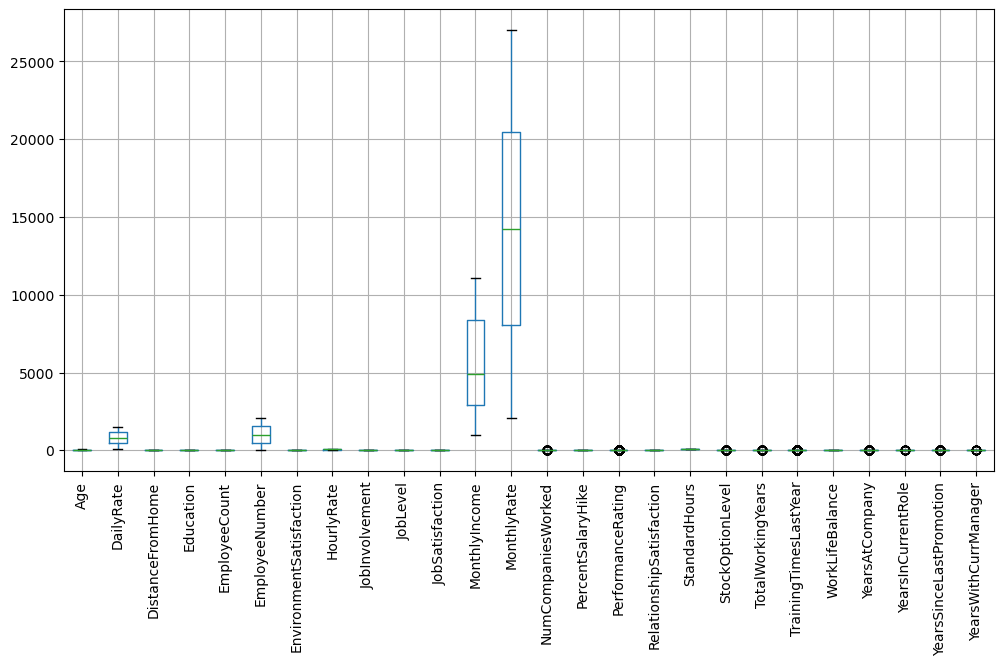

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data.boxplot(column=numeric_column_name)
plt.xticks(rotation=90)
plt.show()

In [36]:
y=data['Attrition']
X=data.drop(['Attrition','EmployeeNumber','StandardHours','EmployeeCount','Over18'], axis=1)

In [37]:
# Separate categorical and numeric columns BEFORE encoding
#cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
#num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [38]:
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

In [39]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for cols in cat_cols:
    le = LabelEncoder()
    X[cols] = le.fit_transform(X[cols].astype(str)) 
    label_encoders[cols] = le

In [40]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

In [41]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
cat_col_indices = [X.columns.get_loc(col) for col in cat_cols]

# Apply SMOTENC
sampling_strategy = {0:1500, 1:1500}
smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=cat_col_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

# Check balance
print(pd.Series(y_resampled).value_counts())

0    1500
1    1500
Name: count, dtype: int64


In [42]:
X_test.head(2)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1061,0.142857,0,0.520774,2,0.428571,0.25,1,1.0,0,0.685714,...,0.0,0.666667,0.333333,0.025,0.333333,0.666667,0.027027,0.000000,0.000000,0.000000
891,0.619048,2,0.726361,1,0.035714,0.00,1,0.0,0,0.600000,...,0.0,1.000000,0.333333,0.250,0.833333,0.666667,0.270270,0.294118,0.466667,0.411765


## XG Boost Classifier

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=0,
    use_label_encoder=False,
    eval_metric='auc',
    early_stopping_rounds=100
)

param_dist = {
    'n_estimators': randint(1000, 6000),     # around your 5000
    'learning_rate': uniform(0.01, 0.2),     # around 0.1    
    'reg_alpha': uniform(0, 2),              # around 1
    'reg_lambda': uniform(1, 10),            # around 6
    'subsample': uniform(0.6, 0.4),          # try subsampling
    'colsample_bytree': uniform(0.6, 0.4)    # for column sampling
}
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter combinations to try
    scoring='roc_auc',  # or 'accuracy', 'f1', etc.
    cv=5,
    verbose=1,
    random_state=0,
    n_jobs=-1  # use all cores
)

# Fit on your resampled data
random_search.fit(X_resampled, y_resampled,
    eval_set=[(X_test, y_test)])
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_xgb_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-auc:0.72607
[1]	validation_0-auc:0.78086
[2]	validation_0-auc:0.79003
[3]	validation_0-auc:0.76673
[4]	validation_0-auc:0.77065
[5]	validation_0-auc:0.76824
[6]	validation_0-auc:0.77483
[7]	validation_0-auc:0.77569
[8]	validation_0-auc:0.78069
[9]	validation_0-auc:0.77940
[10]	validation_0-auc:0.77983
[11]	validation_0-auc:0.78043
[12]	validation_0-auc:0.78056
[13]	validation_0-auc:0.78543
[14]	validation_0-auc:0.78922
[15]	validation_0-auc:0.78637
[16]	validation_0-auc:0.78723
[17]	validation_0-auc:0.78784
[18]	validation_0-auc:0.79051
[19]	validation_0-auc:0.78982
[20]	validation_0-auc:0.79249


D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-auc:0.78922
[22]	validation_0-auc:0.79335
[23]	validation_0-auc:0.78801
[24]	validation_0-auc:0.78999
[25]	validation_0-auc:0.79016
[26]	validation_0-auc:0.79335
[27]	validation_0-auc:0.79447
[28]	validation_0-auc:0.79611
[29]	validation_0-auc:0.79120
[30]	validation_0-auc:0.79137
[31]	validation_0-auc:0.78861
[32]	validation_0-auc:0.79008
[33]	validation_0-auc:0.79025
[34]	validation_0-auc:0.79275
[35]	validation_0-auc:0.79137
[36]	validation_0-auc:0.79249
[37]	validation_0-auc:0.79481
[38]	validation_0-auc:0.79697
[39]	validation_0-auc:0.79852
[40]	validation_0-auc:0.79955
[41]	validation_0-auc:0.79852
[42]	validation_0-auc:0.79748
[43]	validation_0-auc:0.79748
[44]	validation_0-auc:0.80084
[45]	validation_0-auc:0.79998
[46]	validation_0-auc:0.79835
[47]	validation_0-auc:0.79869
[48]	validation_0-auc:0.79809
[49]	validation_0-auc:0.79714
[50]	validation_0-auc:0.79878
[51]	validation_0-auc:0.80033
[52]	validation_0-auc:0.79843
[53]	validation_0-auc:0.79628
[54]	valid

In [70]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(
    colsample_bytree= 0.8470541988303508, 
    learning_rate= 0.13241914454448428, 
    max_depth= 1, 
    n_estimators=1756, 
    reg_alpha=0.7729779622517239, 
    reg_lambda=10.025984755294047, 
    subsample= 0.7799799959644911,
    random_state=0
)

classifier_xgb.fit(X_resampled, y_resampled)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8470541988303508, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13241914454448428,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1756, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [71]:
#test train accuracies
y_pred_test=classifier_xgb.predict(X_test)
y_pred_train=classifier_xgb.predict(X_train)
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)
# Probabilities (for AUC)
y_proba_test = classifier_xgb.predict_proba(X_test)[:, 1]
y_proba_train = classifier_xgb.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)
print("Training AUC:", auc_train)
print("Testing AUC:", auc_test)

training accuracy: 0.9141156462585034
testing accuracy: 0.8741496598639455
training F1_score: 0.7106017191977078
testing F1_score: 0.6105263157894737
Training AUC: 0.9230810291448703
Testing AUC: 0.841071582392971


In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       247
           1       0.60      0.62      0.61        47

    accuracy                           0.87       294
   macro avg       0.77      0.77      0.77       294
weighted avg       0.88      0.87      0.87       294



## LightGBM Classifier with Hyper parameter and early stopping criteria

In [79]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

param_dist = {
    'learning_rate': uniform(0.08, 0.04),       # 0.08 to 0.12
    'n_estimators': randint(4000, 6001),        # inclusive of 6000
    'num_leaves': randint(5, 16),               # 5 to 15
    'reg_alpha': uniform(0.5, 1.0),             # 0.5 to 1.5
    'reg_lambda': randint(1, 11),               # 1 to 10
    'subsample': uniform(0.6, 0.4),             # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4)       # 0.6 to 1.0
}

classifierLGBM = LGBMClassifier(
    early_stopping_rounds=100,  
    eval_metric='auc',         
    n_estimators=5000,         
    random_state=42
)

grid_search = RandomizedSearchCV(
    estimator=classifierLGBM,
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=20,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=1
)


grid_search.fit(
    X_resampled, y_resampled,
    eval_metric='auc',
    eval_set=[(X_test, y_test)]
)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1500, number of negative: 1500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5640
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stop

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(early_stopping_rounds=100,
                                            eval_metric='auc',
                                            n_estimators=5000,
                                            random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.08, 0.1, 0.12],
                                        'n_estimators': [4000, 5000, 6000],
                                        'num_leaves': [5, 10, 15],
                                        'reg_alpha': [0.5, 1, 1.5],
                                        'reg_lambda': [1, 6, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc', verbose=1)

In [47]:
# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best AUC Score: {:.2f}%".format(grid_search.best_score_ * 100))

Best Hyperparameters:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 10, 'n_estimators': 6000, 'learning_rate': 0.12, 'colsample_bytree': 0.6}
Best AUC Score: 98.20%


In [80]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Create LightGBM classifier
classifierLGBM = LGBMClassifier(objective='binary',
                            learning_rate=0.12,
                            n_estimators=6000,
                            max_depth=1,                            
                            num_leaves=10,
                            reg_alpha=0.5, reg_lambda=1.0,subsample= 0.8,colsample_bytree= 0.6,
                            random_state=0)
                            

# Fit the model
classifierLGBM.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 1500, number of negative: 1500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5640
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.12, max_depth=1,
               n_estimators=6000, num_leaves=10, objective='binary',
               random_state=0, reg_alpha=0.5, reg_lambda=1.0, subsample=0.8)

In [81]:
#test train accuracies
y_pred_test=classifierLGBM.predict(X_test)
y_pred_train=classifierLGBM.predict(X_train)
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)
# Probabilities (for AUC)
y_proba_test = classifierLGBM.predict_proba(X_test)[:, 1]
y_proba_train = classifierLGBM.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)
print("Training AUC:", auc_train)
print("Testing AUC:", auc_test)

training accuracy: 0.9268707482993197
testing accuracy: 0.8673469387755102
training F1_score: 0.7556818181818182
testing F1_score: 0.5806451612903226
Training AUC: 0.9378990071527703
Testing AUC: 0.8303902144887586


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       247
           1       0.62      0.62      0.62        47

    accuracy                           0.88       294
   macro avg       0.77      0.77      0.77       294
weighted avg       0.88      0.88      0.88       294



## Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

gbc = GradientBoostingClassifier(
    validation_fraction=0.2,      # enables internal validation set
    n_iter_no_change=50,          # early stopping patience
    tol=1e-4,
    random_state=0
)

param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(1000, 6000),
    'max_depth': randint(1, 5),
    'subsample': uniform(0.6, 0.4),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'learning_rate': 0.2100300146337003, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 3446, 'subsample': 0.8431322674861871}
Best ROC AUC Score: 0.9875955555555554


In [74]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(
    learning_rate=0.2100300146337003,
    n_estimators=3446,
    max_depth=1,
    subsample=0.8431322674861871,
    min_samples_leaf=3,
    min_samples_split=5,
    validation_fraction=0.2,
    n_iter_no_change=50,
    tol=1e-4,
    random_state=0
)

classifier.fit(X_resampled, y_resampled)


GradientBoostingClassifier(learning_rate=0.2100300146337003, max_depth=1,
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=3446, n_iter_no_change=50,
                           random_state=0, subsample=0.8431322674861871,
                           validation_fraction=0.2)

In [75]:
#test train accuracies
y_pred_test=classifier.predict(X_test)
y_pred_train=classifier.predict(X_train)
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)
# Probabilities (for AUC)
y_proba_test = classifier.predict_proba(X_test)[:, 1]
y_proba_train = classifier.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)
print("Training AUC:", auc_train)
print("Testing AUC:", auc_test)

training accuracy: 0.9115646258503401
testing accuracy: 0.8571428571428571
training F1_score: 0.7111111111111111
testing F1_score: 0.5714285714285714
Training AUC: 0.9158695420091812
Testing AUC: 0.8372814195882505


## Catboost

In [76]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,  # silence during tuning
    random_state=42
)

param_dist = {
    'iterations': randint(1000, 5000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(1, 6),
    'l2_leaf_reg': randint(1, 150),
    'random_strength': uniform(1, 5),
    'bagging_temperature': uniform(0, 1.5),
    'class_weights': [[1, 1.2], [1, 1.5], [1, 2.0]]  # example weights
}

fit_params = {
    'eval_set': (X_test, y_test),
    'early_stopping_rounds': 100,
    'verbose': 100
}

random_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled, **fit_params)

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

best_catboost_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	test: 0.6471703	best: 0.6471703 (0)	total: 7.3ms	remaining: 28.4s
100:	test: 0.7947282	best: 0.8060126 (44)	total: 552ms	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8060125764
bestIteration = 44

Shrink model to first 45 iterations.
Best Parameters: {'bagging_temperature': 1.2899106101044808, 'class_weights': [1, 2.0], 'depth': 5, 'iterations': 3888, 'l2_leaf_reg': 18, 'learning_rate': 0.19977710745066668, 'random_strength': 5.828160165372797}
Best ROC AUC Score: 0.975288888888889


In [77]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier(
    iterations=3888,
    learning_rate=0.19977710745066668,
    depth=1,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=100,
    l2_leaf_reg=18,
    random_strength=5.828160165372797,
    bagging_temperature=1.2899106101044808,
    class_weights=[1, 2.0],  # Example for binary class imbalance
    verbose=100,
    random_state=42
)

classifier.fit(X_resampled, y_resampled, eval_set=(X_test, y_test))


0:	test: 0.5166681	best: 0.5166681 (0)	total: 2.42ms	remaining: 9.41s
100:	test: 0.7986907	best: 0.8084245 (45)	total: 244ms	remaining: 9.15s
200:	test: 0.8172969	best: 0.8172969 (200)	total: 475ms	remaining: 8.72s
300:	test: 0.8247050	best: 0.8261694 (289)	total: 717ms	remaining: 8.54s
400:	test: 0.8306486	best: 0.8306486 (400)	total: 985ms	remaining: 8.56s
500:	test: 0.8309932	best: 0.8346972 (475)	total: 1.24s	remaining: 8.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8346972177
bestIteration = 475

Shrink model to first 476 iterations.


In [78]:
#test train accuracies
y_pred_test=classifier.predict(X_test)
y_pred_train=classifier.predict(X_train)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)
# Probabilities (for AUC)
y_proba_test = classifier.predict_proba(X_test)[:, 1]
y_proba_train = classifier.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)
print("Training AUC:", auc_train)
print("Testing AUC:", auc_test)

training accuracy: 0.8707482993197279
testing accuracy: 0.7959183673469388
training F1_score: 0.6637168141592921
testing F1_score: 0.5161290322580645
Training AUC: 0.9113590263691684
Testing AUC: 0.8346972176759411


## Using deep learning method with hyperparameter

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
#Model development
def model(hp):
    ann = tf.keras.models.Sequential()

    # Hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    l2_regularizer = hp.Float('l2_regularizer', min_value=0.0001, max_value=0.01, step=0.001)
    kernel_initializer = hp.Choice('kernel_initializer', values=['he_uniform', 'glorot_uniform', 'lecun_normal'])
    activation = hp.Choice('activation', values=['relu', 'tanh', 'LeakyReLU'])

    # input layer
    ann.add(tf.keras.layers.Input(shape=(X_resampled.shape[1],)
    ))
    #first hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(256,kernel_initializer=kernel_initializer, activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)        
    ))
    #second hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(128,kernel_initializer=kernel_initializer,activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))
    #Third hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(64,kernel_initializer=kernel_initializer,activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))
    #output layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(1,kernel_initializer=kernel_initializer, activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

    return ann

# Create the tuner with 10 trials and save in folder
tuner = kt.RandomSearch(
    model,  
    objective='val_loss',  
    max_trials=20, 
    directory='cap_project'
    )
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_auc',       # Monitor validation loss (you can change this to 'val_mae' if needed)
    patience=5,               # Number of epochs to wait for improvement (you can adjust this)
    restore_best_weights=True # Restore the best model weights after early stopping
)
# Perform hyperparameter tuning
tuner.search(X_resampled, y_resampled, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping],class_weight={0: 1, 1: 5} )

Reloading Tuner from cap_project\untitled_project\tuner0.json


In [83]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'learning_rate': 0.003806871387360406,
 'l2_regularizer': 0.0061,
 'kernel_initializer': 'glorot_uniform',
 'activation': 'relu'}

In [84]:
best_model = tuner.get_best_models(num_models=1)[0]

In [85]:
# evaluate model
val_loss, val_auc = best_model.evaluate(X_test, y_test)
print("\nBest Model Validation AUC:", val_auc)
print("\nBest Model Validation Loss:", val_loss)  

10/10 [==============================] - 1s 7ms/step - loss: 1.3198 - auc: 0.8124

Best Model Validation AUC: 0.8123869299888611

Best Model Validation Loss: 1.3198480606079102


## Best Model XGBoost

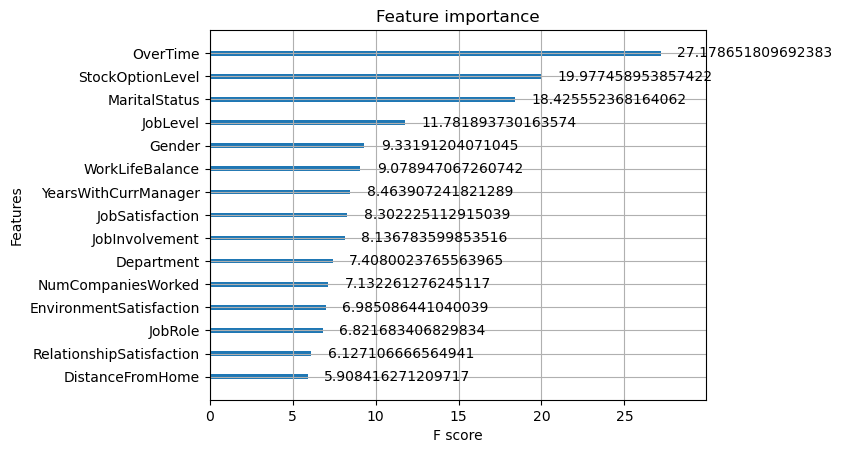

In [90]:
import matplotlib.pyplot as plt
import xgboost as xgb
xgb.plot_importance(classifier_xgb, importance_type='gain', max_num_features=15)
plt.show()

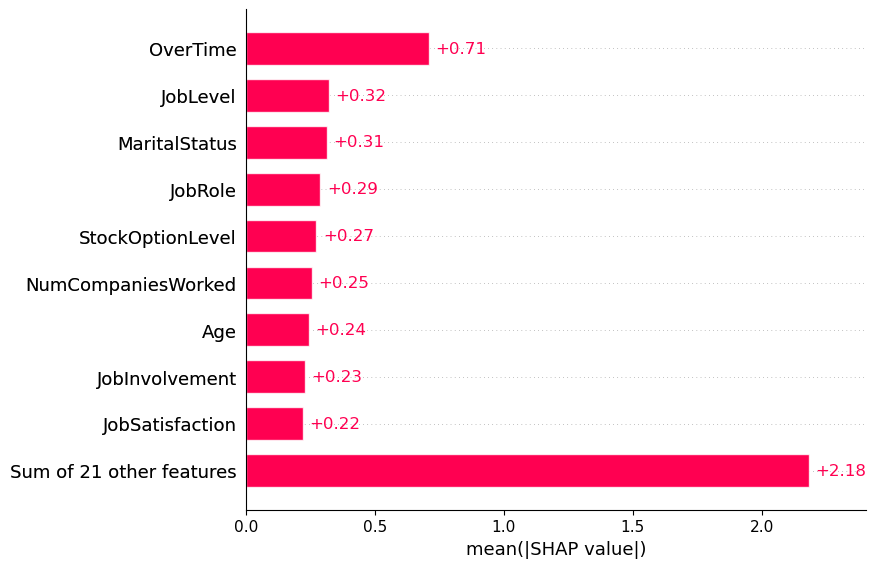

In [91]:
import shap
import numpy as np

# Only needed once per session
shap.initjs()
background = X_resampled.sample(100, random_state=42)

explainer = shap.Explainer(best_xgb_model, background)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)